## Linear Regression

Consider the following linear equation:

\begin{equation}
y_i = \alpha +x_i\beta
\end{equation}

The equation says that there is a linear relation between the variable $x$ and $y$. The parameter $\beta$ controls the slope of the linear relationship and thus is interpreted as the change in the variable $y$ per unit change in the variable $x$. $\alpha$ is known as the intercept, and gives the value of $y$ when $x=0$.

Traditional methods of linear modelling is the least square fit method.

However thiniking probabilistically gives us several advantages, we can obtain the best value of $\alpha$ and $\beta$ together with the uncertainty we have about the parameters value.

Probabilitistically , a linear regression can be modeled as follows:

\begin{equation}
y\sim N\left(\mu=\alpha+x\beta, \epsilon\right)
\end{equation}

This implies that the data vector $y$ is assumed to be distributed as a Gaussian with a mean of $\alpha + x\beta$ and a standard deviation of $\epsilon$. 

Since we do not know the values of $\alpha$, $\beta$ or $\epsilon$ we have to set prior distributions for them. A reasonable choice would be:

\begin{equation}
\alpha \sim N\left(\mu_{\alpha}, \sigma_{\alpha}\right)\\
\beta \sim N\left(\mu_{\beta}, \sigma_{\beta}\right)\\
\epsilon \sim |N\left(0, \sigma_{\epsilon}\right)|
\end{equation}

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


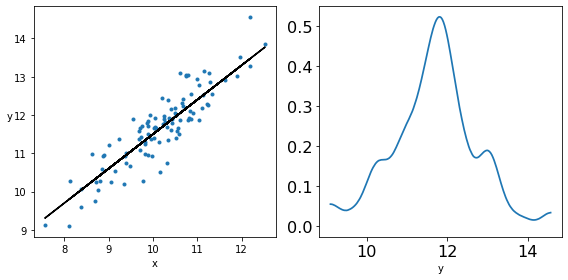

In [2]:
np.random.seed(1)
N = 100
alpha_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alpha_real + beta_real * x
y = y_real + eps_real

_, ax = plt.subplots(1,2, figsize=(8, 4))
ax[0].plot(x, y, 'C0.')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y', rotation=0)
ax[0].plot(x, y_real, 'k')
az.plot_kde(y, ax=ax[1])
ax[1].set_xlabel('y')
plt.tight_layout()

Let us create a linear regression model in pymc3.

In [3]:
with pm.Model() as model_g:
    α = pm.Normal('α', mu=0, sd=10)
    β = pm.Normal('β', mu=0, sd=1)
    ϵ = pm.HalfCauchy('ϵ', 5)

    μ = pm.Deterministic('μ', α + β * x)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y)

    trace_g = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.
There were 48 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7164597467916465, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


$\mu$ is expressed in the model as a deterministic variable. To explore the results of our inference we are going to generate a trace plot, omitting the deterministic variables. We can do this passing only the names of the variables we want to plot.

In [4]:
sns.set()

array([[<AxesSubplot:title={'center':'α'}>,
        <AxesSubplot:title={'center':'α'}>],
       [<AxesSubplot:title={'center':'β'}>,
        <AxesSubplot:title={'center':'β'}>],
       [<AxesSubplot:title={'center':'ϵ'}>,
        <AxesSubplot:title={'center':'ϵ'}>]], dtype=object)

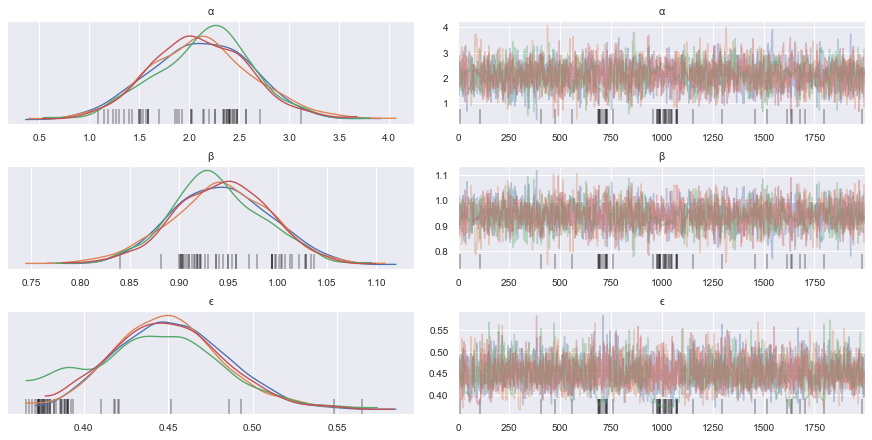

In [5]:
az.plot_trace(trace_g, var_names=['α', 'β', 'ϵ'])

## Linear models and high auto correlation

Linear models have a posterior distribution where $\alpha$ and $\beta$ are highly correlated. Let us look at the example above:

<AxesSubplot:xlabel='α', ylabel='β'>

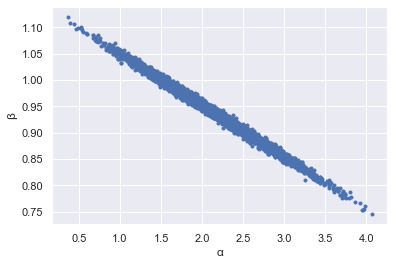

In [6]:
az.plot_pair(trace_g, var_names=['α', 'β'], plot_kwargs={'alpha': 0.01})

The correlation that we see is a consequence of one of the key assumptions, that all fitted models should pass through one point, namely the mean of the data $\left(\bar{x}, \bar{y}\right)$.



## Modifying the data before running

One way to remove the correlation between $\alpha$ and $\beta$ is to center $x$ variable. For each $x_i$ data point we subtract the mean $\bar{x}$.
\begin{equation}
x'=x-\bar{x}
\end{equation}
Thus $x'$ will be centered at the origin 0, hence the pivot point when changing the slope is exactly the intercept and the $\alpha$ and $\beta$ are less correlated now.

## Interpreting and visualizing the posterior

For linear regression it would be useful to plot the average line that fits the data, together with the average mean values of $\alpha$ and $\beta$. To reflect the posterior's uncertainty, we can use semi-transparent lines that have beens sampled from the posterior.

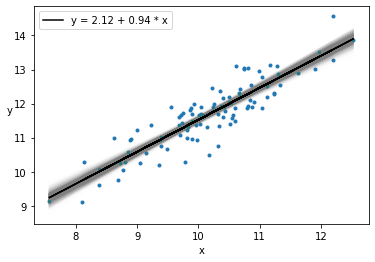

In [9]:
plt.plot(x, y, 'C0.')

alpha_m = trace_g['α'].mean()
beta_m = trace_g['β'].mean()

draws = range(0, len(trace_g['α']), 10)
plt.plot(x, trace_g['α'][draws] + trace_g['β'][draws]
         * x[:, np.newaxis], c='gray', alpha=0.01)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.legend()

The uncertainty is lower at the middle of the plot, although it is not reduced to a single point, that is posterior is compatible with lines not exactly passing throgh the mean of the data.

Another interesting fact we can represent on the plot is the HPD interval of $\mu$.

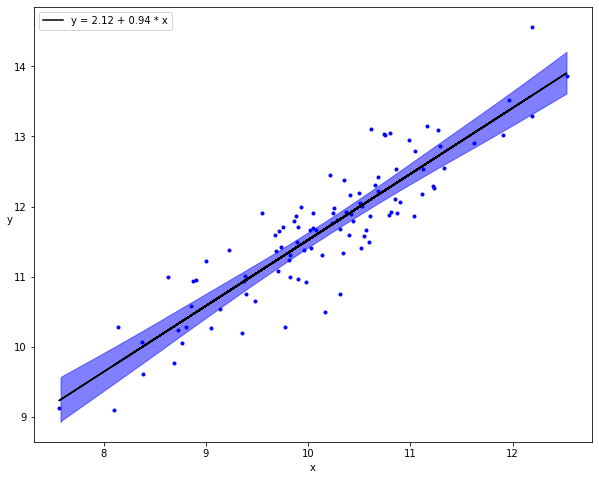

In [19]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(x, y, 'b.')
ax.plot(x, alpha_m + beta_m * x, c='k',          
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x') 
sig = az.plot_hpd(x, trace_g['μ'], credible_interval=0.98, color='b', ax=ax)
ax.set_xlabel('x')
ax.set_ylabel('y', rotation=0)
ax.legend(loc='best')

One more option is to plot the HPD of the predicted data $\hat{y}$, i.e. where we expect to see the 94% and the 50 % of the future data, according to our model.

We can get the posterior predictive samples using the 'sample_posterior_predictive()' function.

In [16]:
ppc = pm.sample_posterior_predictive(trace_g,
                                     samples=2000,
                                     model=model_g)

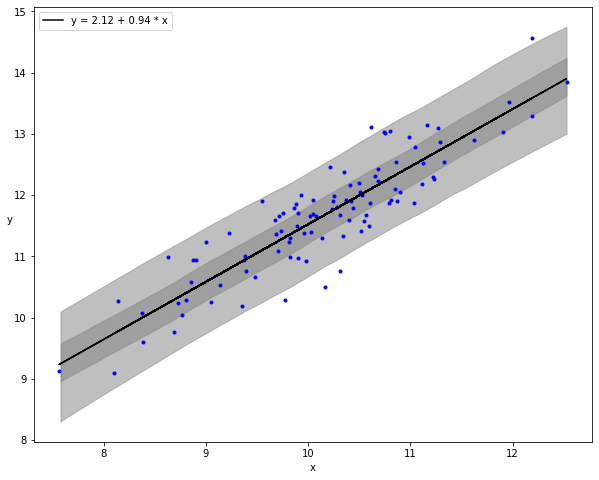

In [23]:
_, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(x, y, 'b.')
ax.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hpd(x, ppc['y_pred'], credible_interval=0.5, color='gray', ax=ax, smooth=True)
az.plot_hpd(x, ppc['y_pred'], color='gray', ax=ax, smooth=True)

ax.set_xlabel('x')
ax.set_ylabel('y', rotation=0)
ax.legend(loc='best')

The 'az.plot_hpd' function smoothen the interval, in order to remove that, use 'smooth=False' in the options.